<a href="https://colab.research.google.com/github/siddhantkd/FY_HGS/blob/main/AEC_EE_Model_SKD_LinkNET%5BRESNET18%5D_3_ASPP%5B256%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# **AEC _ EE - NET** 

3. ResNet18_LINKNET with ASPP

LINKNET _ ASPP [ 512 deconv filters ]

BEST 30 epochs

> F - 0.9801724121093752

> IoU socre is:  0.8403416923529685

ASPP [ 256 deconv filters ]

> F 0.9805174218749996

> IOU : IoU socre is:  0.8417632228496972 / 0.8403  ( no y test change )

> Epochs 60 ( CONVERGED ) 



#IMPORT AND DRIVE LOAD

In [1]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [2]:
!nvidia-smi

Fri Dec 31 03:59:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [43]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


#Data Loading

In [ ]:
!unzip '/content/drive/MyDrive/OUHANDS/OUHANDS_Siddhant.zip'

In [5]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

In [6]:
path = "/content/OUHANDS_Siddhant/training/colour"
maskpath = "/content/OUHANDS_Siddhant/training/segmentation"

X_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating input data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_train[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_train[m]=mpg/255
    m+=1

creating input data


100%|██████████| 2000/2000 [00:03<00:00, 583.14it/s]


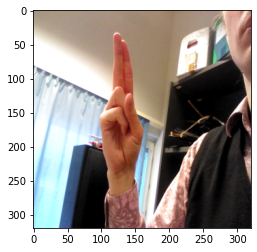

In [ ]:
plt.imshow(array_to_img(X_train[0]))

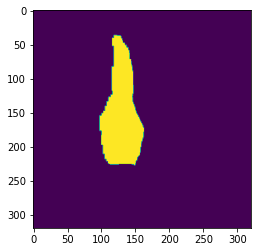

In [ ]:
plt.imshow(array_to_img(Y_train[0]))

In [ ]:
print(X_train.shape, Y_train.shape)

(2000, 320, 320, 3) (2000, 320, 320, 1)


# AEC_EE Model

In [7]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Conv2DTranspose, Add, AveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git

In [9]:
import keras
from classification_models.keras import Classifiers

In [10]:
def ASPP(inputs):

    conv_filters = 256
    """ Image Pooling """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(conv_filters, 1, padding="same", use_bias=False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    """ 1x1 conv """
    y2 = Conv2D(conv_filters, 1, padding="same", use_bias=False)(inputs)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    """ 3x3 conv rate=6 """
    y3 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    """ 3x3 conv rate=12 """
    y4 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    """ 3x3 conv rate=18 """
    y5 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(conv_filters, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

In [11]:
"""Skip connections as per SM Models LINKnet with backbone Resnet 18"""

# LATEST MODEL - LINKNET only

def build_UNET_Resnet19():    
  ResNet18, preprocess_input = Classifiers.get('resnet18')
  model = ResNet18(input_shape=(320,320,3), include_top=False)
  model.load_weights("/content/drive/MyDrive/FY_HGS/AEC_EE_Unet_Resnet18_SKD/resnet18_imagenet_1000_no_top.h5")

  """ Skip Connections """

  s1 = model.get_layer("relu0").output                      ## (160, 160)
  s2 = model.get_layer("stage2_unit1_relu1").output         ## ( 80, 80)
  s3 = model.get_layer("stage3_unit1_relu1").output         ## (40, 40)
  s4 = model.get_layer("stage4_unit1_relu1").output         ## (20, 20)

  #print(s1.shape, s2.shape, s3.shape, s4.shape)

  """ Bridge """

  b1 = model.get_layer("relu1").output
  b1 = ASPP(b1)
  #print(b1.shape)

  """ Decoder """
  x = Conv2D(128, (3,3), kernel_initializer='he_normal', padding = 'same')(b1)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(128, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(256, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s4]) # ADD 1

  x = Conv2D(64, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(64, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(128, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s3]) # ADD 2

  x = Conv2D(32, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(32, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s2]) # ADD 3

  x = Conv2D(16, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(16, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s1]) # ADD 4

  x = Conv2D(16, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(16, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(16, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  outputs = Conv2D(1, 1, kernel_initializer='he_normal',padding="same")(x)
  outputs = Activation('sigmoid')(outputs)

  model = keras.models.Model(inputs=[model.input], outputs=[outputs])  

  #print(model.summary())

  return model

In [13]:
model = build_UNET_Resnet19()
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 320, 320, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']   

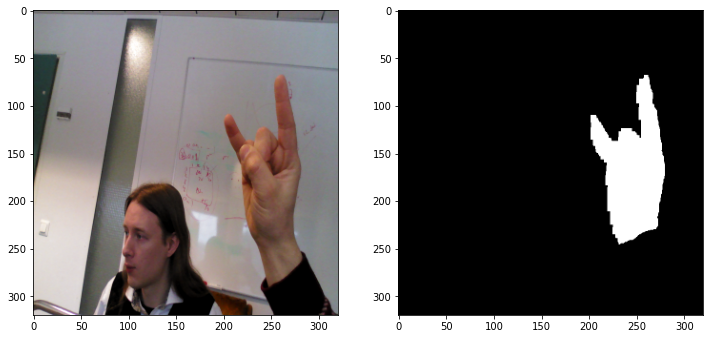

In [12]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number])
plt.subplot(122)
plt.imshow(array_to_img(Y_train[image_number]), cmap='gray')
plt.show()

In [14]:
from tensorflow.keras.optimizers import Adam

In [15]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [16]:
model.compile(loss=dice_loss, optimizer=Adam(1e-4), metrics=[dice_coef, iou])

# MODEL TRAINING

##20 epochs

In [17]:
#Model Checkpoint
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP[256]/cp.ckpt"
model_checkpoint_segmentUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentUNET,
                                                 save_weights_only=True,
                                                  monitor='val_loss',save_best_only=True,
                                                 verbose=1)

In [18]:
history = model.fit(X_train,Y_train,validation_split = 0.1,batch_size=8,epochs=20, callbacks=[model_checkpoint_segmentUNET])

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.5929 - dice_coef: 0.4071 - iou: 0.2587
Epoch 00001: val_loss improved from inf to 0.59047, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP[256]/cp.ckpt
225/225 [==============================] - 118s 441ms/step - loss: 0.5929 - dice_coef: 0.4071 - iou: 0.2587 - val_loss: 0.5905 - val_dice_coef: 0.4095 - val_iou: 0.2586
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.5014 - dice_coef: 0.4986 - iou: 0.3343
Epoch 00002: val_loss improved from 0.59047 to 0.49252, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP[256]/cp.ckpt
225/225 [==============================] - 99s 438ms/step - loss: 0.5014 - dice_coef: 0.4986 - iou: 0.3343 - val_loss: 0.4925 - val_dice_coef: 0.5075 - val_iou: 0.3414
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.4659 - dice_coef: 0.5341 - iou: 0.3662
Epoch 00003: val_loss improved from 0.49252 to

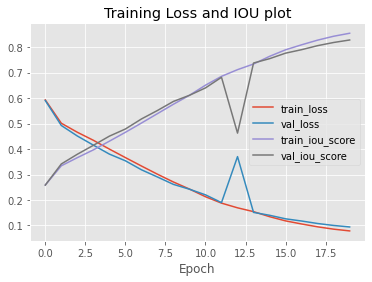

In [19]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 20
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), history.history["iou"], label = "train_iou_score")
plt.plot(np.arange(0,N), history.history["val_iou"], label = "val_iou_score")
plt.legend(loc="center right")
plt.title("Training Loss and IOU plot")
plt.xlabel("Epoch")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

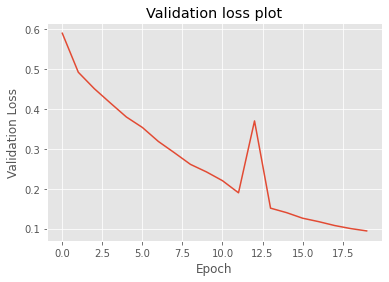

In [20]:
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('UNET_ValLossPlot_SEGMENTATION_V1.2.png')

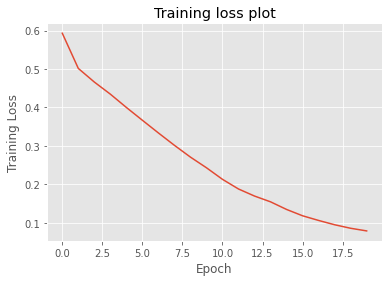

In [21]:
plt.plot(np.arange(0,N), history.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

##30 Epochs

In [ ]:
checkpoint_path_segmentUNET = ""
model.load_weights(checkpoint_path_segmentUNET)

In [22]:
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP[256]/30/cp.ckpt"
model_checkpoint_segmentUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentUNET,
                                                 save_weights_only=True,
                                                  monitor='val_loss',save_best_only=True,
                                                 verbose=1)

In [23]:
h2 =  model.fit(X_train,Y_train,validation_split = 0.1,batch_size=8,epochs=10,callbacks=[model_checkpoint_segmentUNET])

Epoch 1/10
225/225 [==============================] - ETA: 0s - loss: 0.0717 - dice_coef: 0.9283 - iou: 0.8666
Epoch 00001: val_loss improved from inf to 0.08819, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP[256]/30/cp.ckpt
225/225 [==============================] - 99s 438ms/step - loss: 0.0717 - dice_coef: 0.9283 - iou: 0.8666 - val_loss: 0.0882 - val_dice_coef: 0.9118 - val_iou: 0.8382
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 0.0652 - dice_coef: 0.9348 - iou: 0.8778
Epoch 00002: val_loss improved from 0.08819 to 0.08504, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP[256]/30/cp.ckpt
225/225 [==============================] - 99s 440ms/step - loss: 0.0652 - dice_coef: 0.9348 - iou: 0.8778 - val_loss: 0.0850 - val_dice_coef: 0.9150 - val_iou: 0.8435
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 0.0602 - dice_coef: 0.9398 - iou: 0.8866
Epoch 00003: val_loss improved from 0.085

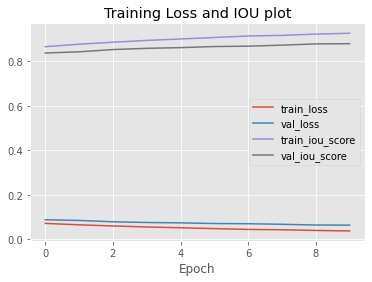

In [24]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 10
plt.plot(np.arange(0,N), h2.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h2.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h2.history["iou"], label = "train_iou_score")
plt.plot(np.arange(0,N), h2.history["val_iou"], label = "val_iou_score")
plt.legend(loc="center right")
plt.title("Training Loss and IOU plot")
plt.xlabel("Epoch")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

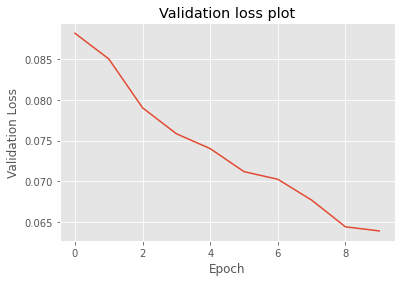

In [25]:
plt.plot(np.arange(0,N), h2.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('UNET_ValLossPlot_SEGMENTATION_V1.2.png')

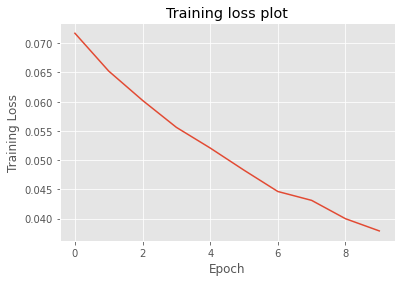

In [26]:
plt.plot(np.arange(0,N), h2.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

## 40

In [27]:
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP[256]/40/cp.ckpt"
model_checkpoint_segmentUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentUNET,
                                                 save_weights_only=True,
                                                  monitor='val_loss',save_best_only=True,
                                                 verbose=1)

In [28]:
h3 =  model.fit(X_train,Y_train,validation_split = 0.1,batch_size=8,epochs=10,callbacks=[model_checkpoint_segmentUNET])

Epoch 1/10
225/225 [==============================] - ETA: 0s - loss: 0.0364 - dice_coef: 0.9636 - iou: 0.9298
Epoch 00001: val_loss improved from inf to 0.06164, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP[256]/40/cp.ckpt
225/225 [==============================] - 101s 449ms/step - loss: 0.0364 - dice_coef: 0.9636 - iou: 0.9298 - val_loss: 0.0616 - val_dice_coef: 0.9384 - val_iou: 0.8840
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 0.0342 - dice_coef: 0.9658 - iou: 0.9339
Epoch 00002: val_loss improved from 0.06164 to 0.06076, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP[256]/40/cp.ckpt
225/225 [==============================] - 99s 440ms/step - loss: 0.0342 - dice_coef: 0.9658 - iou: 0.9339 - val_loss: 0.0608 - val_dice_coef: 0.9392 - val_iou: 0.8856
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 0.0331 - dice_coef: 0.9669 - iou: 0.9361
Epoch 00003: val_loss did not improve fr

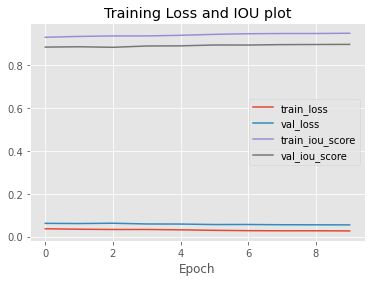

In [29]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 10
plt.plot(np.arange(0,N), h3.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h3.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h3.history["iou"], label = "train_iou_score")
plt.plot(np.arange(0,N), h3.history["val_iou"], label = "val_iou_score")
plt.legend(loc="center right")
plt.title("Training Loss and IOU plot")
plt.xlabel("Epoch")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

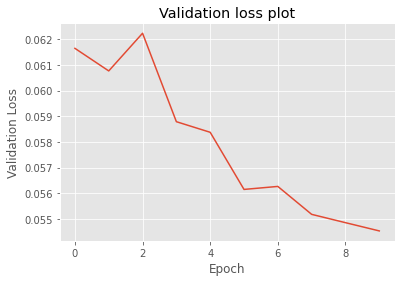

In [30]:
plt.plot(np.arange(0,N), h3.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('UNET_ValLossPlot_SEGMENTATION_V1.2.png')

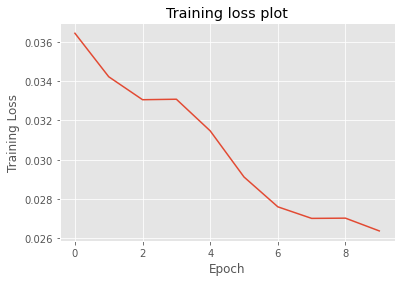

In [31]:
plt.plot(np.arange(0,N), h3.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

## 50

In [45]:
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP_256/50/cp.ckpt"
model_checkpoint_segmentUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentUNET,
                                                 save_weights_only=True,
                                                  monitor='val_loss',save_best_only=True,
                                                 verbose=1)

In [50]:
h4 =  model.fit(X_train,Y_train,validation_split = 0.1,batch_size=8,epochs=10,callbacks=[model_checkpoint_segmentUNET])

Epoch 1/10
225/225 [==============================] - ETA: 0s - loss: 0.0251 - dice_coef: 0.9749 - iou: 0.9510
Epoch 00001: val_loss improved from inf to 0.05396, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP_256/50/cp.ckpt
225/225 [==============================] - 99s 441ms/step - loss: 0.0251 - dice_coef: 0.9749 - iou: 0.9510 - val_loss: 0.0540 - val_dice_coef: 0.9460 - val_iou: 0.8977
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 0.0241 - dice_coef: 0.9759 - iou: 0.9530
Epoch 00002: val_loss improved from 0.05396 to 0.05324, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP_256/50/cp.ckpt
225/225 [==============================] - 101s 448ms/step - loss: 0.0241 - dice_coef: 0.9759 - iou: 0.9530 - val_loss: 0.0532 - val_dice_coef: 0.9468 - val_iou: 0.8990
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 0.0236 - dice_coef: 0.9764 - iou: 0.9538
Epoch 00003: val_loss did not improve from

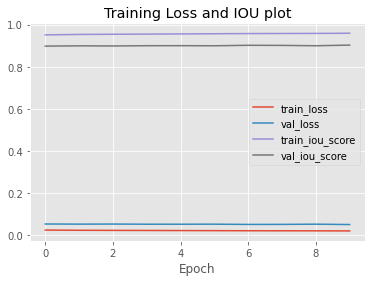

In [51]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 10
plt.plot(np.arange(0,N), h4.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h4.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h4.history["iou"], label = "train_iou_score")
plt.plot(np.arange(0,N), h4.history["val_iou"], label = "val_iou_score")
plt.legend(loc="center right")
plt.title("Training Loss and IOU plot")
plt.xlabel("Epoch")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

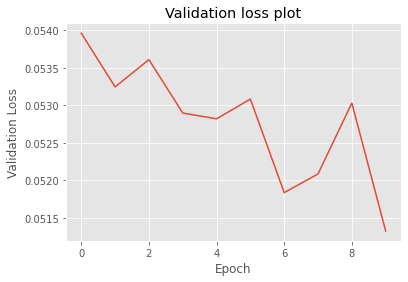

In [52]:
plt.plot(np.arange(0,N), h4.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('UNET_ValLossPlot_SEGMENTATION_V1.2.png')

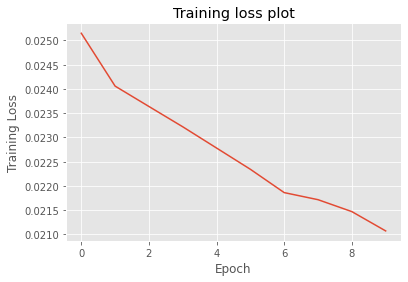

In [53]:
plt.plot(np.arange(0,N), h4.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

## 60

In [59]:
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP_256/60/cp.ckpt"
model_checkpoint_segmentUNET = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentUNET,
                                                 save_weights_only=True,
                                                  monitor='val_loss',save_best_only=True,
                                                 verbose=1)

In [60]:
h5 =  model.fit(X_train,Y_train,validation_split = 0.1,batch_size=8,epochs=10,callbacks=[model_checkpoint_segmentUNET])

Epoch 1/10
225/225 [==============================] - ETA: 0s - loss: 0.0209 - dice_coef: 0.9791 - iou: 0.9590
Epoch 00001: val_loss improved from inf to 0.05104, saving model to /content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP_256/60/cp.ckpt
225/225 [==============================] - 98s 436ms/step - loss: 0.0209 - dice_coef: 0.9791 - iou: 0.9590 - val_loss: 0.0510 - val_dice_coef: 0.9490 - val_iou: 0.9030
Epoch 2/10
225/225 [==============================] - ETA: 0s - loss: 0.0207 - dice_coef: 0.9793 - iou: 0.9594
Epoch 00002: val_loss did not improve from 0.05104
225/225 [==============================] - 97s 432ms/step - loss: 0.0207 - dice_coef: 0.9793 - iou: 0.9594 - val_loss: 0.0520 - val_dice_coef: 0.9480 - val_iou: 0.9013
Epoch 3/10
225/225 [==============================] - ETA: 0s - loss: 0.0205 - dice_coef: 0.9795 - iou: 0.9599
Epoch 00003: val_loss did not improve from 0.05104
225/225 [==============================] - 97s 432ms/step - loss: 0.0205 - dice_coef: 0

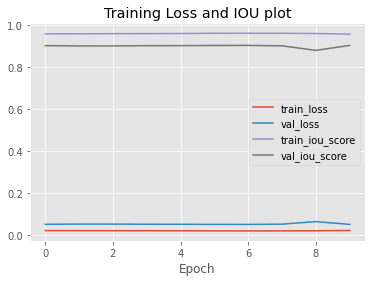

In [61]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 10
plt.plot(np.arange(0,N), h5.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), h5.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), h5.history["iou"], label = "train_iou_score")
plt.plot(np.arange(0,N), h5.history["val_iou"], label = "val_iou_score")
plt.legend(loc="center right")
plt.title("Training Loss and IOU plot")
plt.xlabel("Epoch")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

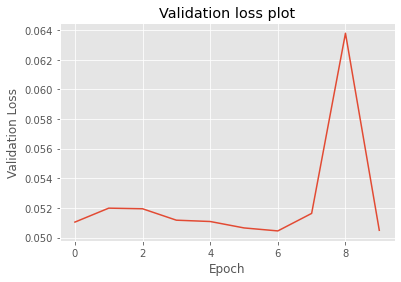

In [62]:
plt.plot(np.arange(0,N), h5.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.savefig('UNET_ValLossPlot_SEGMENTATION_V1.2.png')

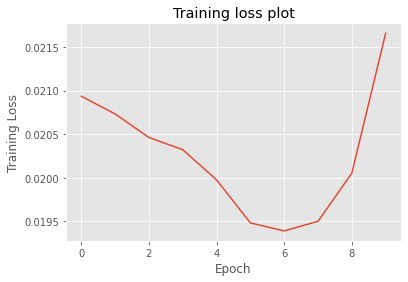

In [63]:
plt.plot(np.arange(0,N), h5.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.savefig('UNET_TrainLossPlot_SEGMENTATION_V1.2.png')

# **EVALUATION**

In [32]:
path = "/content/OUHANDS_Siddhant/testing/colour"
maskpath = "/content/OUHANDS_Siddhant/testing/segmentation"
p1 = os.listdir(path)
p1.sort()

m1 = os.listdir(maskpath)
m1.sort()

X_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating test data')
n=0
for name in tqdm(p1):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_test[n]=img
    n+=1

m=0
for name in tqdm(m1):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_test[m]=mpg/255
    m+=1

creating test data


100%|██████████| 1000/1000 [00:03<00:00, 283.58it/s]


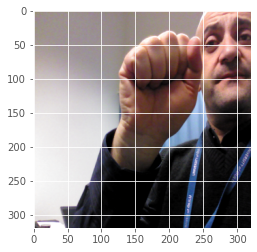

In [ ]:
plt.imshow(X_test[0])

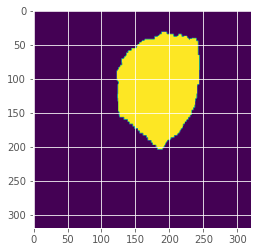

In [ ]:
plt.imshow(array_to_img(Y_test[0]))

In [33]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import f1_score

In [34]:
def fscore(tp,Images,Masks):
    total=0
    i=0
    fs=0
    for i in range(len(Images)):
        total += 1
        
        tp[i][tp[i]>0.5]=1
        tp[i][tp[i]<0.5]=0

        pred = img_to_array(tp[i]).astype(int)
        label = img_to_array(np.squeeze(Masks[i], axis=2)).astype(int)
        flat_pred = np.ravel(pred)
        flat_label = np.ravel(label)

        fs += f1_score(flat_label,flat_pred, average='micro')

    fs=fs/total

    return fs  

##20 epochs

In [ ]:
model.save("")

In [ ]:
 #    ######evaluate#####
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP/cp.ckpt"
model.load_weights(checkpoint_path_segmentUNET)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9783507031249992


AEC_EE_RESNET 18 encoder LINKNET

20 epochs 

IoU socre is: 0.8299967067687382

F - 0.9783507031249992



In [ ]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8299967067687382


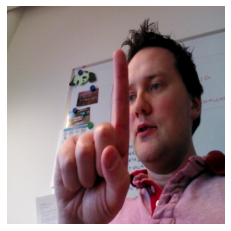

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test[270]))
#plt.title('TEST IMAGE')

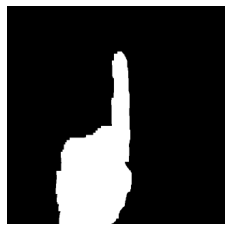

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(Y_test[270]), cmap = 'gray')
#plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

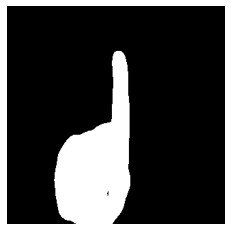

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred[270]), cmap = 'gray')
#plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

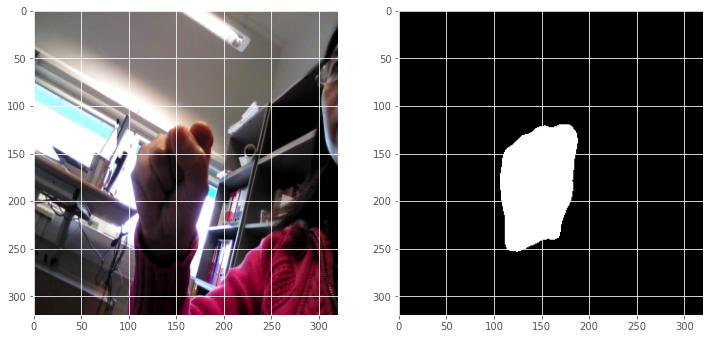

In [ ]:
#Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()

In [ ]:
x_test_single = np.expand_dims(X_test[200], axis = 0)

In [ ]:
import time
start_time = time.time()
y_single = model.predict(x_test_single)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.15967488288879395 seconds ---


##30Epochs

In [ ]:
 #    ######evaluate#####
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP_256/30/cp.ckpt"
model.load_weights(checkpoint_path_segmentUNET)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9801724121093752


LINKNET _ ASPP 

F - 0.9801724121093752

IoU socre is:  0.8403416923529685


In [ ]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8403416923529685


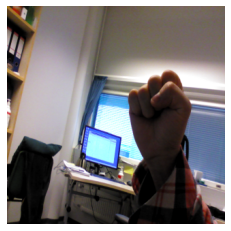

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(X_test[50]))
#plt.title('TEST IMAGE')

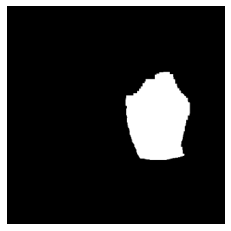

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(Y_test[50]), cmap = 'gray')
#plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

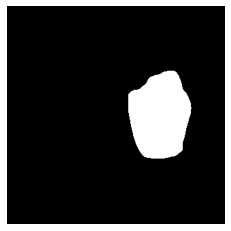

In [ ]:
plt.grid(False)
plt.axis('off')
plt.imshow(array_to_img(y_pred[50]), cmap = 'gray')
#plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

In [ ]:
#Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()

In [ ]:
import time
x_test_single = np.expand_dims(X_test[8], axis = 0)

start_time = time.time()
y_single = model.predict(x_test_single)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.08934760093688965 seconds ---


## 40 epochs

In [46]:
 #    ######evaluate#####
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP_256/40/cp.ckpt"
model.load_weights(checkpoint_path_segmentUNET)

In [47]:
y_pred=model.predict(X_test)

In [48]:
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9804387890624996


In [49]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8384248466308086


IoU socre is:  0.8384248466308086

F - 0.9804387890624996

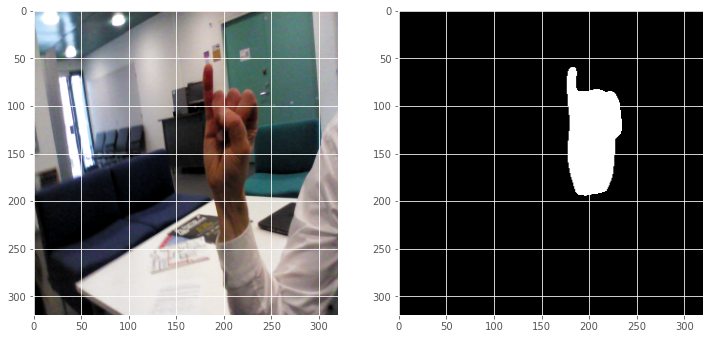

In [39]:
#Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()

## 50

In [ ]:
 #    ######evaluate#####
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP_256/50/cp.ckpt"
model.load_weights(checkpoint_path_segmentUNET)

In [54]:
y_pred=model.predict(X_test)

In [55]:
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9803434277343746


In [56]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8391686908272772


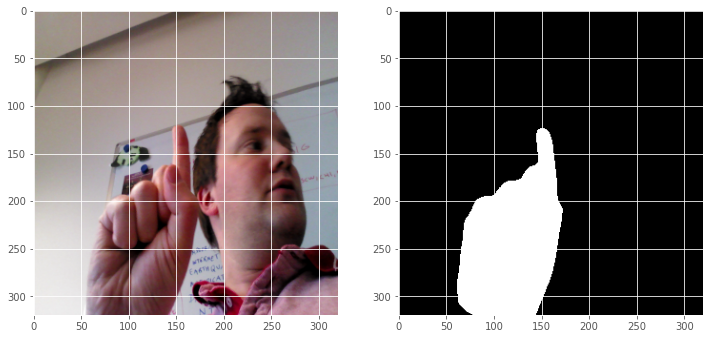

In [58]:
#Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()

## 60 

In [64]:
 #    ######evaluate#####
checkpoint_path_segmentUNET = "/content/drive/MyDrive/FY_HGS/AEC_EE_LINKNET_Resnet18/ASPP_256/60/cp.ckpt"
model.load_weights(checkpoint_path_segmentUNET)

In [65]:
y_pred=model.predict(X_test)

In [66]:
f=fscore(y_pred,X_test,Y_test)
print(f)

0.9805174218749996


In [70]:
y_pred_thresholded = y_pred > 0.5
Y_test = Y_test > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8417632228496972


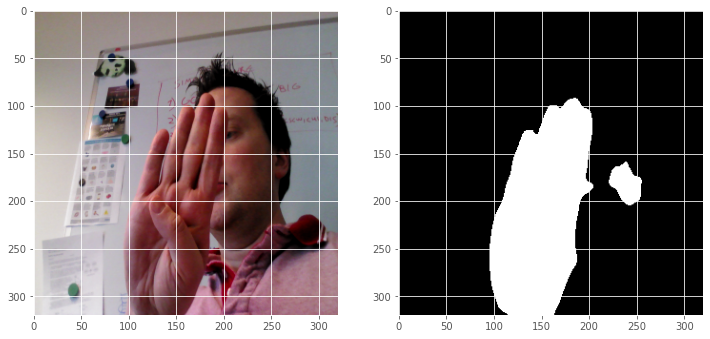

In [68]:
#Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()

#SAVE THE MODEL

In [ ]:
model.save("")